In [1]:
# Importing all necessery libraries.
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from keras.layers import Dense
from keras.models import Sequential

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
import os

from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb

2023-07-10 17:11:40.323689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Wine_Quality_Prediction:
    
    
    def __init__(self):
        self.df=None
        self.X=None
        self.y=None
        self.X_train=None
        self.X_test=None
        self.y_train=None
        self.y_test=None
        self.rfe_cols=None
        self.X_train_sm=None
        self.lm=None
        self.vif=None
        self.history_regression=None
        self.model=None
        self.y_train_pred=None
        self.y_test_pred=None
        
    
    def read_data(self):
        self.df=pd.read_csv("wine_quality.csv",header=0)

        return self.df
    
    def dataset_shape(self):
        return self.df.shape
    
    
    def dataset_info(self):
        return self.df.info()
    
    def dataset_round(self):
        data=self.df
        data[data.columns]=data[data.columns].round(3)
        return data
    
    def dataset_null_check(self):
        data=self.df
        null=data.isnull().sum()
        return null


    def dataset_null_value_set(self):
        data=self.df
        null=self.dataset_null_check()
        for i,j in enumerate(null):
            if j>0:
                
                data[data.columns[i]].fillna(math.floor(data[data.columns[i]].mean()),inplace=True)
        self.df=data        
   
        return data.isnull().sum()

    def dataset_corelation_heatmap(self):
        data=self.df
        print(data.density)
        plt.figure(figsize=(30,20))
        sns.heatmap(data.corr(),annot=True,cmap="OrRd")
        plt.title("Heatmap",fontdict={"fontsize":30,"fontweight":10,"color":"Purple"})
        plt.show()
        
    def dataset_pair_plot(self):
        data=self.df
        cols = data.columns
        sns.pairplot(data[cols[0:-2]])
        return plt.show()
    def outlier(self):
        data=self.df
        n=data.shape[1]
        for i in range(n):
            q1=data[data.columns[i]].quantile(0.25)
            q3=data[data.columns[i]].quantile(0.75)
            value=q3-q1
            low=q1-1.5*value
            high=q3+1.5*value
            result=data[(data[data.columns[i]]<high)&(data[data.columns[i]]>low)]
        self.df=result  
        return self.df
        
    def dataset_split_Xy(self):
        self.y=self.df["quality"]
        self.X=self.df.drop("quality",axis=1)
        return self.X,self.y
    
    def oversampler_dataset(self):
        ros = RandomOverSampler(random_state=42)
        print('Original dataset shape', self.y.shape)

        # fit predictor and target variable
        self.X,self.y = ros.fit_resample(self.X,self.y)
        print('Resample dataset shape', self.y.shape)
        
        print(self.X)
        print("_-------")
        print(self.y)
    
    
    def scaled_data(self):
        scaled=StandardScaler()
        cols=self.X.columns
        self.X[cols]=scaled.fit_transform(self.X[cols])
        return self.X
    
    def dataset_train_validation_split(self):
        self.X_train,self.X_test,self.y_train,self.y_test=train_test_split(self.X,self.y,train_size=0.8,random_state=42)
        return self.X_train,self.X_test,self.y_train,self.y_test
        
        
    
    
    def rfe_cols_name(self):
        logis=LogisticRegression()
        rfe=RFE(logis)
        rfe=rfe.fit(self.X_train,self.y_train)
        self.rfe_cols=self.X_train.columns[rfe.support_]
        self.X_train=self.X_train[self.rfe_cols]
        self.X_test=self.X_test[self.rfe_cols]
        return self.X_train
            
    def model_vif(self):
        self.vif=pd.DataFrame()
        self.vif["Features"]=self.X_train.columns
        self.vif["vif"]=[variance_inflation_factor(self.X_train.values,i) for i in range(self.X_train.shape[1])]
        self.vif["vif"]=round(self.vif["vif"],2)
        self.vif=self.vif.sort_values(by="vif",ascending=False)
        return self.vif
    
    def quality_predict_regression(self):    
        self.model=Sequential()
        self.model.add(Dense(128,activation=tf.nn.relu))
        self.model.add(Dense(256,activation=tf.nn.relu))
        self.model.add(Dense(256,activation=tf.nn.relu))
        self.model.add(Dense(512,activation=tf.nn.relu))
        self.model.add(Dense(512,activation=tf.nn.relu))
        self.model.add(Dense(1024,activation=tf.nn.relu))
        self.model.add(Dense(1024,activation=tf.nn.relu))
        self.model.add(Dense(1024,activation=tf.nn.relu))
        self.model.add(Dense(1,activation="linear"))
        
        opt=tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.9,beta_2=0.999)
        
        self.model.compile(optimizer=opt,loss="mean_squared_error")

        self.history=self.model.fit(self.X_train,self.y_train, batch_size=42, epochs=200,validation_split=0.1)

        self.y_train_pred=self.model.predict(self.X_train)
        self.y_test_pred=self.model.predict(self.X_test)
        
        print("r2_score for train data:",r2_score(self.y_train,self.y_train_pred))
        print("r2_score for validation data",r2_score(self.y_test,self.y_test_pred))
        print(self.X_train)

        
        
        
    def Regression_training_graph_show(self):
        plt.plot(self.history.history["loss"],label="Loss")
        plt.title("Graph of loss vs epochs")
        plt.plot(self.history.history["val_loss"],label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Losses")
        plt.show()
        
        
    def set_data_for_classification(self): 
        for items in self.y.iteritems():
            if items[1]<=3.0:
                self.y.update({items[0]:0})
            elif items[1]<=6.0:
                self.y.update({items[0]:1})
            elif items[1]<=10.0:
                self.y.update({items[0]:2})
              
        
   
            
        
    def quality_predict_classification(self):
        self.y_train=pd.get_dummies(y_train)
        self.y_test=pd.get_dummies(y_test)
        
        self.model=Sequential()
        self.model.add(Dense(256,activation=tf.nn.relu))
        self.model.add(Dense(256,activation=tf.nn.relu))
        self.model.add(Dense(256,activation=tf.nn.relu))
        self.model.add(Dense(512,activation=tf.nn.relu))
        self.model.add(Dense(512,activation=tf.nn.relu))
        self.model.add(Dense(1024,activation=tf.nn.relu))
        self.model.add(Dense(3,activation="sigmoid"))
        opt=tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.9,beta_2=0.999)
        self.model.compile(optimizer=opt,loss=keras.losses.categorical_crossentropy)

        self.history=self.model.fit(self.X_train,self.y_train, batch_size=32, epochs=200,validation_split=0.2)

        self.y_train_pred=self.model.predict(self.X_train)
        self.y_test_pred=self.model.predict(self.X_test)
      
        
        print("r2_score for train data:",r2_score(self.y_train,self.y_train_pred))
        print("r2_score for validation data",r2_score(self.y_test,self.y_test_pred))
        
        
        
        
    def Classification_training_graph_show(self):
        plt.plot(self.history.history["loss"],label="Loss")
        plt.title("Grapf of loss vs epochs")
        plt.plot(self.history.history["val_loss"],label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Losses")
        plt.show()
        
    def get_quality_of_wine(self,dataset):
        if ((dataset.split(".")[1])=="csv"):
            df=pd.read_csv(dataset,header=0)
        elif ((dataset.split(".")[1])=="xlsx"):   
            df=pd.read_excel(dataset,header=0)
        
        df.dropna(inplace=True)    
   
        new_df=df.copy()
        scaled=StandardScaler()
        cols=df.columns
        
        df[cols]=scaled.fit_transform(df[cols])
        
        y=self.model.predict(df)
        
        df=pf.concat([new_df,y],axis=1)
        
        return df
    
    
    def final_dataset(self):
        
        self.X_train["quality"]=self.y_train
        self.X_train["quality_predict"]=pd.Series(self.y_train_pred.reshape(-1))
        
        self.X_train["quality_predict"].fillna(self.X_train["quality_predict"].median(),inplace=True)
        self.X_train["quality"]=self.X_train["quality"].apply(lambda x:math.floor(x))
        self.X_train["quality_predict"]=self.X_train["quality_predict"].apply(lambda x:math.floor(x))
        
        print(self.X_train)
        
            
            
        
        
        
        
            
            
        
        
        
        

        



## Classification Model 

In [32]:
w=Wine_Quality_Prediction()

In [33]:
w.read_data()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5.0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5.0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6.0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.52,0.58,10.5,5.0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.52,0.75,11.0,6.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.52,0.71,10.2,5.0


In [34]:
w.dataset_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1598 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1598 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1598 non-null   float64
dtypes: float64(12)
memory usage: 150.0 KB


In [35]:
w.dataset_round()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,5.0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.997,3.20,0.68,9.8,5.0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5.0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6.0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.995,3.52,0.58,10.5,5.0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.995,3.52,0.76,11.2,6.0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.996,3.52,0.75,11.0,6.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.995,3.52,0.71,10.2,5.0


In [36]:
w.dataset_null_check()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    1
density                 0
pH                      1
sulphates               0
alcohol                 0
quality                 1
dtype: int64

In [37]:
w.dataset_null_value_set()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

0       0.998
1       0.997
2       0.997
3       0.998
4       0.998
        ...  
1594    0.995
1595    0.995
1596    0.996
1597    0.995
1598    0.995
Name: density, Length: 1599, dtype: float64


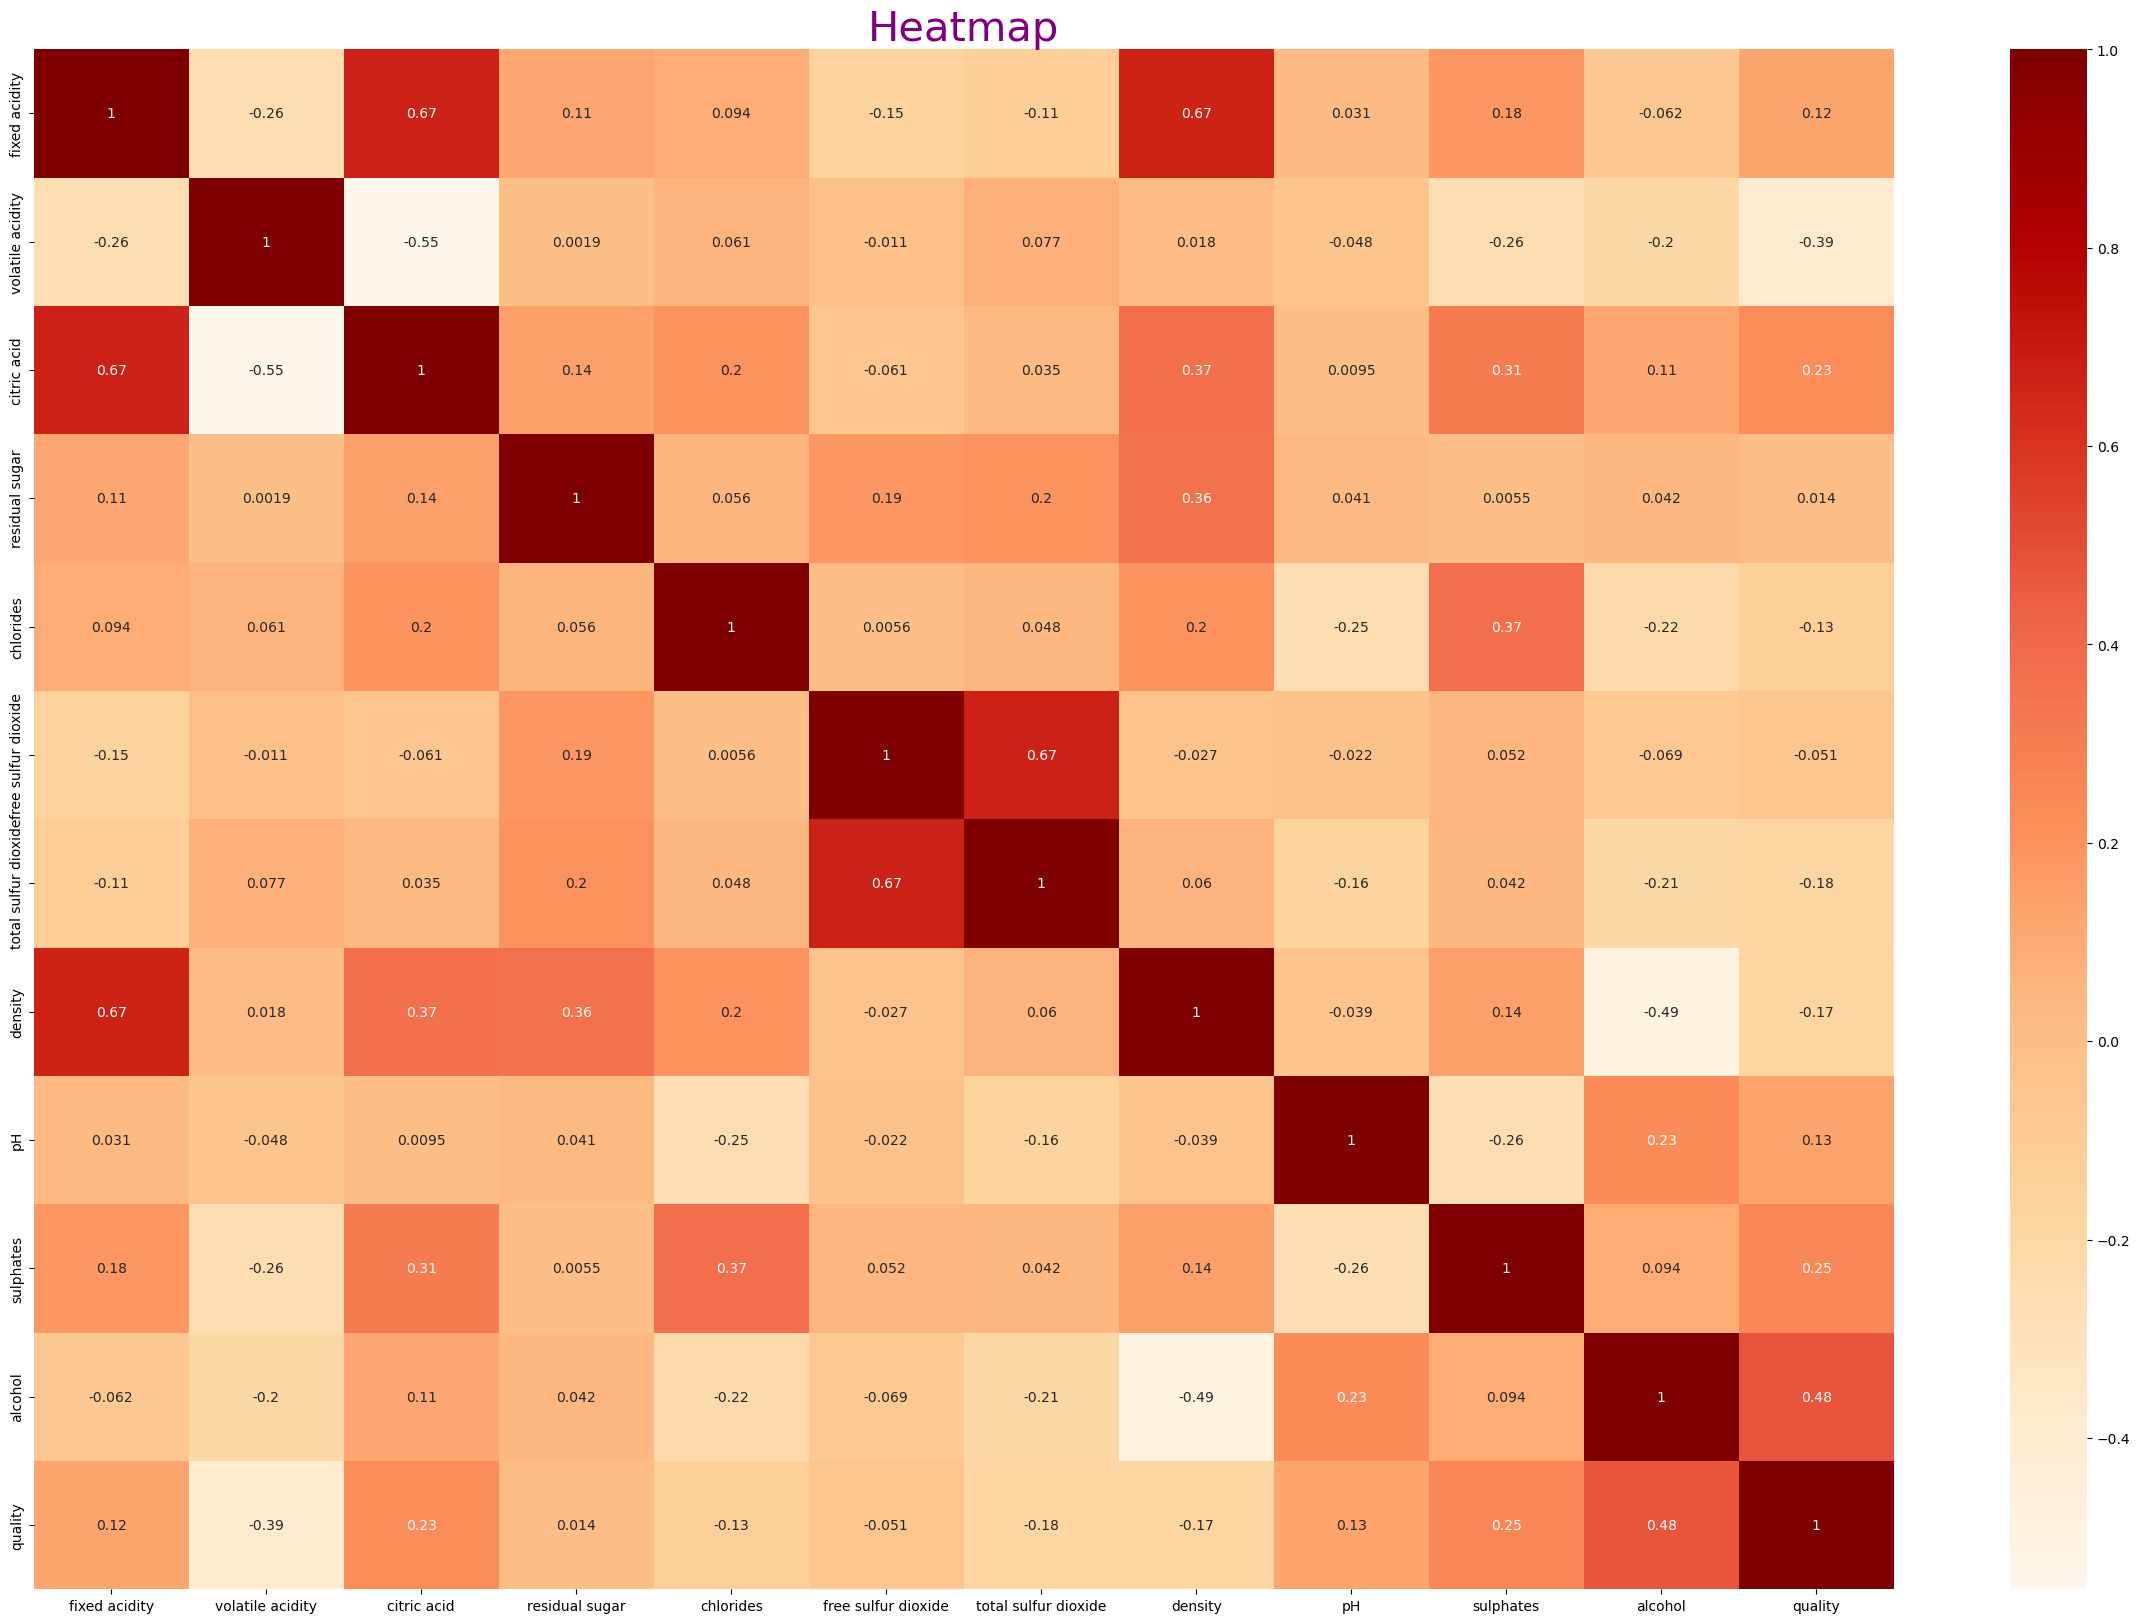

In [38]:
w.dataset_corelation_heatmap()

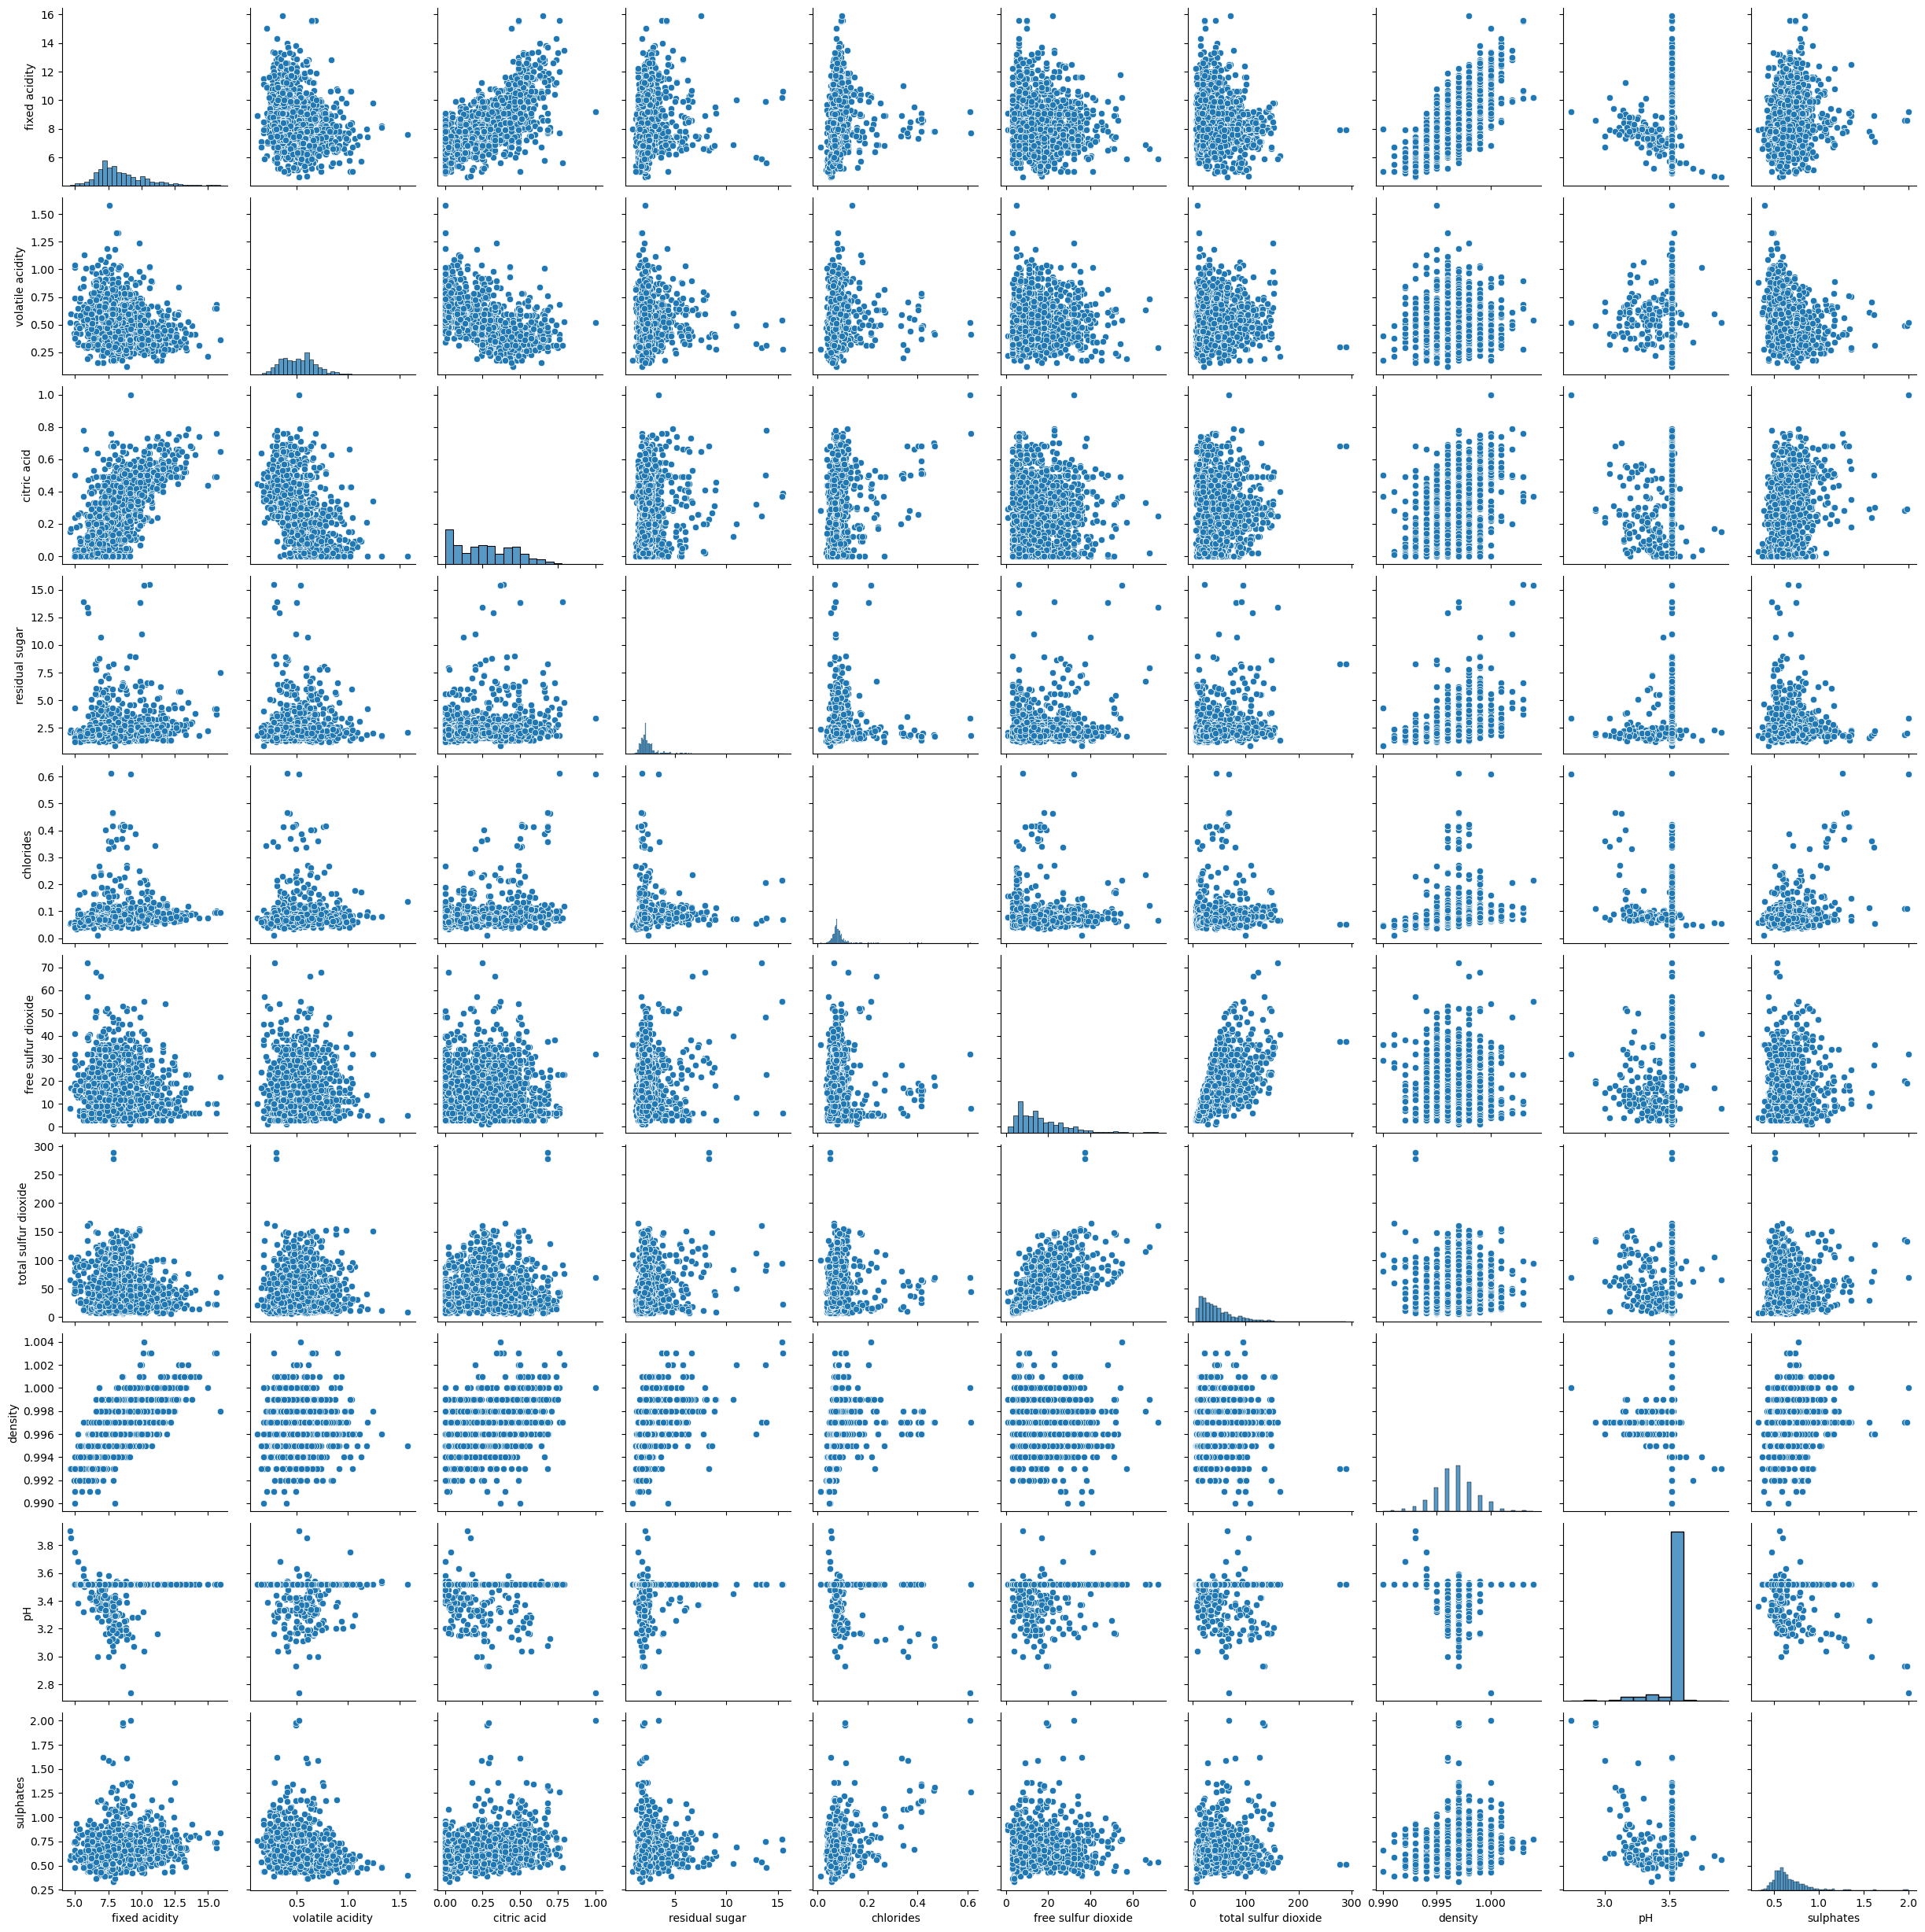

In [39]:
w.dataset_pair_plot()

In [40]:
# w.outlier()

In [41]:
w.dataset_split_Xy()


(      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0               7.4             0.700         0.00             1.9      0.076   
 1               7.8             0.880         0.00             2.6      0.098   
 2               7.8             0.760         0.04             2.3      0.092   
 3              11.2             0.280         0.56             1.9      0.075   
 4               7.4             0.700         0.00             1.9      0.076   
 ...             ...               ...          ...             ...        ...   
 1594            6.2             0.600         0.08             2.0      0.090   
 1595            5.9             0.550         0.10             2.2      0.062   
 1596            6.3             0.510         0.13             2.3      0.076   
 1597            5.9             0.645         0.12             2.0      0.075   
 1598            6.0             0.310         0.47             3.6      0.067   
 
       free su

In [42]:
w.oversampler_dataset()

Original dataset shape (1599,)
Resample dataset shape (4086,)
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
4081           12.6              0.31         0.72             2.2      0.072   
4082           12.6              0.31         0.72             2.2      0.072   
4083            8.6              0.42         0.39             1.8      0.068   
4084            5.0              0.42         0.24             2.0      0.060   
4085            5.0              0.42         0

In [43]:
w.scaled_data()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.510355,0.476596,-1.235048,-0.495999,-0.251461,-0.282611,-0.141383,0.692961,0.066348,-0.580708,-1.063952
1,-0.294607,1.176131,-1.235048,-0.015457,0.152765,1.090688,0.976203,0.216368,-3.682124,0.092180,-0.743751
2,-0.294607,0.709774,-1.054845,-0.221404,0.042522,0.109760,0.535942,0.216368,-2.956613,-0.076042,-0.743751
3,1.539251,-1.155653,1.287795,-0.495999,-0.269834,0.305946,0.739140,0.692961,-4.165798,-0.468560,-0.743751
4,-0.510355,0.476596,-1.235048,-0.495999,-0.251461,-0.282611,-0.141383,0.692961,0.066348,-0.580708,-1.063952
...,...,...,...,...,...,...,...,...,...,...,...
4081,2.294369,-1.039064,2.008608,-0.290052,-0.324956,-0.773075,-0.310714,1.169554,0.187267,0.877217,-0.743751
4082,2.294369,-1.039064,2.008608,-0.290052,-0.324956,-0.773075,-0.310714,1.169554,0.187267,0.877217,-0.743751
4083,0.136889,-0.611570,0.521932,-0.564648,-0.398452,-0.773075,-0.886440,-0.736818,0.187267,0.148255,0.777206
4084,-1.804844,-0.611570,-0.153830,-0.427350,-0.545443,0.502131,0.400477,-2.166596,0.187267,0.428625,2.618364


In [44]:
w.set_data_for_classification()

In [45]:
X_train,X_test,y_train,y_test=w.dataset_train_validation_split()
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3268, 11), (818, 11), (3268,), (818,))

In [46]:
w.rfe_cols_name()

,volatile acidity,free sulfur dioxide,total sulfur dioxide,pH,alcohol
2185,0.709774,-0.773075,-0.886440,0.187267,-0.623675
2462,1.720213,0.305946,-0.480045,0.187267,0.376954
2819,0.010239,-1.067353,-0.988039,0.187267,-0.343499
1769,2.361454,-0.871168,-0.818708,0.187267,-0.023298
1373,0.670911,1.973523,1.721261,0.187267,-1.144003
...,...,...,...,...,...
1130,0.087965,-0.871168,-0.954173,0.187267,-0.263449
1294,0.223986,1.090688,0.739140,0.187267,0.136803
860,0.165691,0.109760,1.585796,0.187267,-0.983902
3507,0.165691,-0.773075,-0.649377,0.187267,2.138062


In [47]:
w.model_vif()

,Features,vif
1,free sulfur dioxide,1.87
2,total sulfur dioxide,1.86
4,alcohol,1.11
3,pH,1.08
0,volatile acidity,1.07


In [48]:
w.quality_predict_classification()

Epoch 1/200
82/82 [==============================] - 1s 5ms/step - loss: 0.6004 - val_loss: 0.4291
Epoch 2/200
82/82 [==============================] - 0s 4ms/step - loss: 0.4151 - val_loss: 0.3329
Epoch 3/200
82/82 [==============================] - 0s 4ms/step - loss: 0.3394 - val_loss: 0.3202
Epoch 4/200
82/82 [==============================] - 0s 4ms/step - loss: 0.3178 - val_loss: 0.3121
Epoch 5/200
82/82 [==============================] - 0s 4ms/step - loss: 0.3183 - val_loss: 0.3001
Epoch 6/200
82/82 [==============================] - 0s 4ms/step - loss: 0.2857 - val_loss: 0.2978
Epoch 7/200
82/82 [==============================] - 0s 4ms/step - loss: 0.2822 - val_loss: 0.3628
Epoch 8/200
82/82 [==============================] - 0s 4ms/step - loss: 0.2711 - val_loss: 0.2626
Epoch 9/200
82/82 [==============================] - 0s 4ms/step - loss: 0.2488 - val_loss: 0.2786
Epoch 10/200
82/82 [==============================] - 0s 3ms/step - loss: 0.2400 - val_loss: 0.2767
Epoch 11/

82/82 [==============================] - 0s 4ms/step - loss: 0.0504 - val_loss: 0.1898
Epoch 84/200
82/82 [==============================] - 0s 4ms/step - loss: 0.0239 - val_loss: 0.2020
Epoch 85/200
82/82 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.1829
Epoch 86/200
82/82 [==============================] - 0s 4ms/step - loss: 0.0334 - val_loss: 0.2712
Epoch 87/200
82/82 [==============================] - 0s 4ms/step - loss: 0.0471 - val_loss: 0.2182
Epoch 88/200
82/82 [==============================] - 0s 4ms/step - loss: 0.0534 - val_loss: 0.2107
Epoch 89/200
82/82 [==============================] - 0s 4ms/step - loss: 0.0729 - val_loss: 0.2210
Epoch 90/200
82/82 [==============================] - 0s 4ms/step - loss: 0.0684 - val_loss: 0.2197
Epoch 91/200
82/82 [==============================] - 0s 4ms/step - loss: 0.0788 - val_loss: 0.2606
Epoch 92/200
82/82 [==============================] - 0s 4ms/step - loss: 0.0639 - val_loss: 0.1830
Epoch 93/200


## Regression Model

In [49]:
new_model=Wine_Quality_Prediction()

In [50]:
new_model.read_data()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5.0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5.0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6.0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.52,0.58,10.5,5.0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.52,0.75,11.0,6.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.52,0.71,10.2,5.0


In [51]:
new_model.dataset_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1598 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1598 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1598 non-null   float64
dtypes: float64(12)
memory usage: 150.0 KB


In [52]:
new_model.dataset_null_check()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    1
density                 0
pH                      1
sulphates               0
alcohol                 0
quality                 1
dtype: int64

In [53]:
new_model.dataset_null_value_set()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [54]:
new_model.dataset_round()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,5.0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.997,3.20,0.68,9.8,5.0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5.0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6.0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.995,3.52,0.58,10.5,5.0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.995,3.52,0.76,11.2,6.0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.996,3.52,0.75,11.0,6.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.995,3.52,0.71,10.2,5.0


In [55]:
new_model.dataset_shape()

(1599, 12)

0       0.998
1       0.997
2       0.997
3       0.998
4       0.998
        ...  
1594    0.995
1595    0.995
1596    0.996
1597    0.995
1598    0.995
Name: density, Length: 1599, dtype: float64


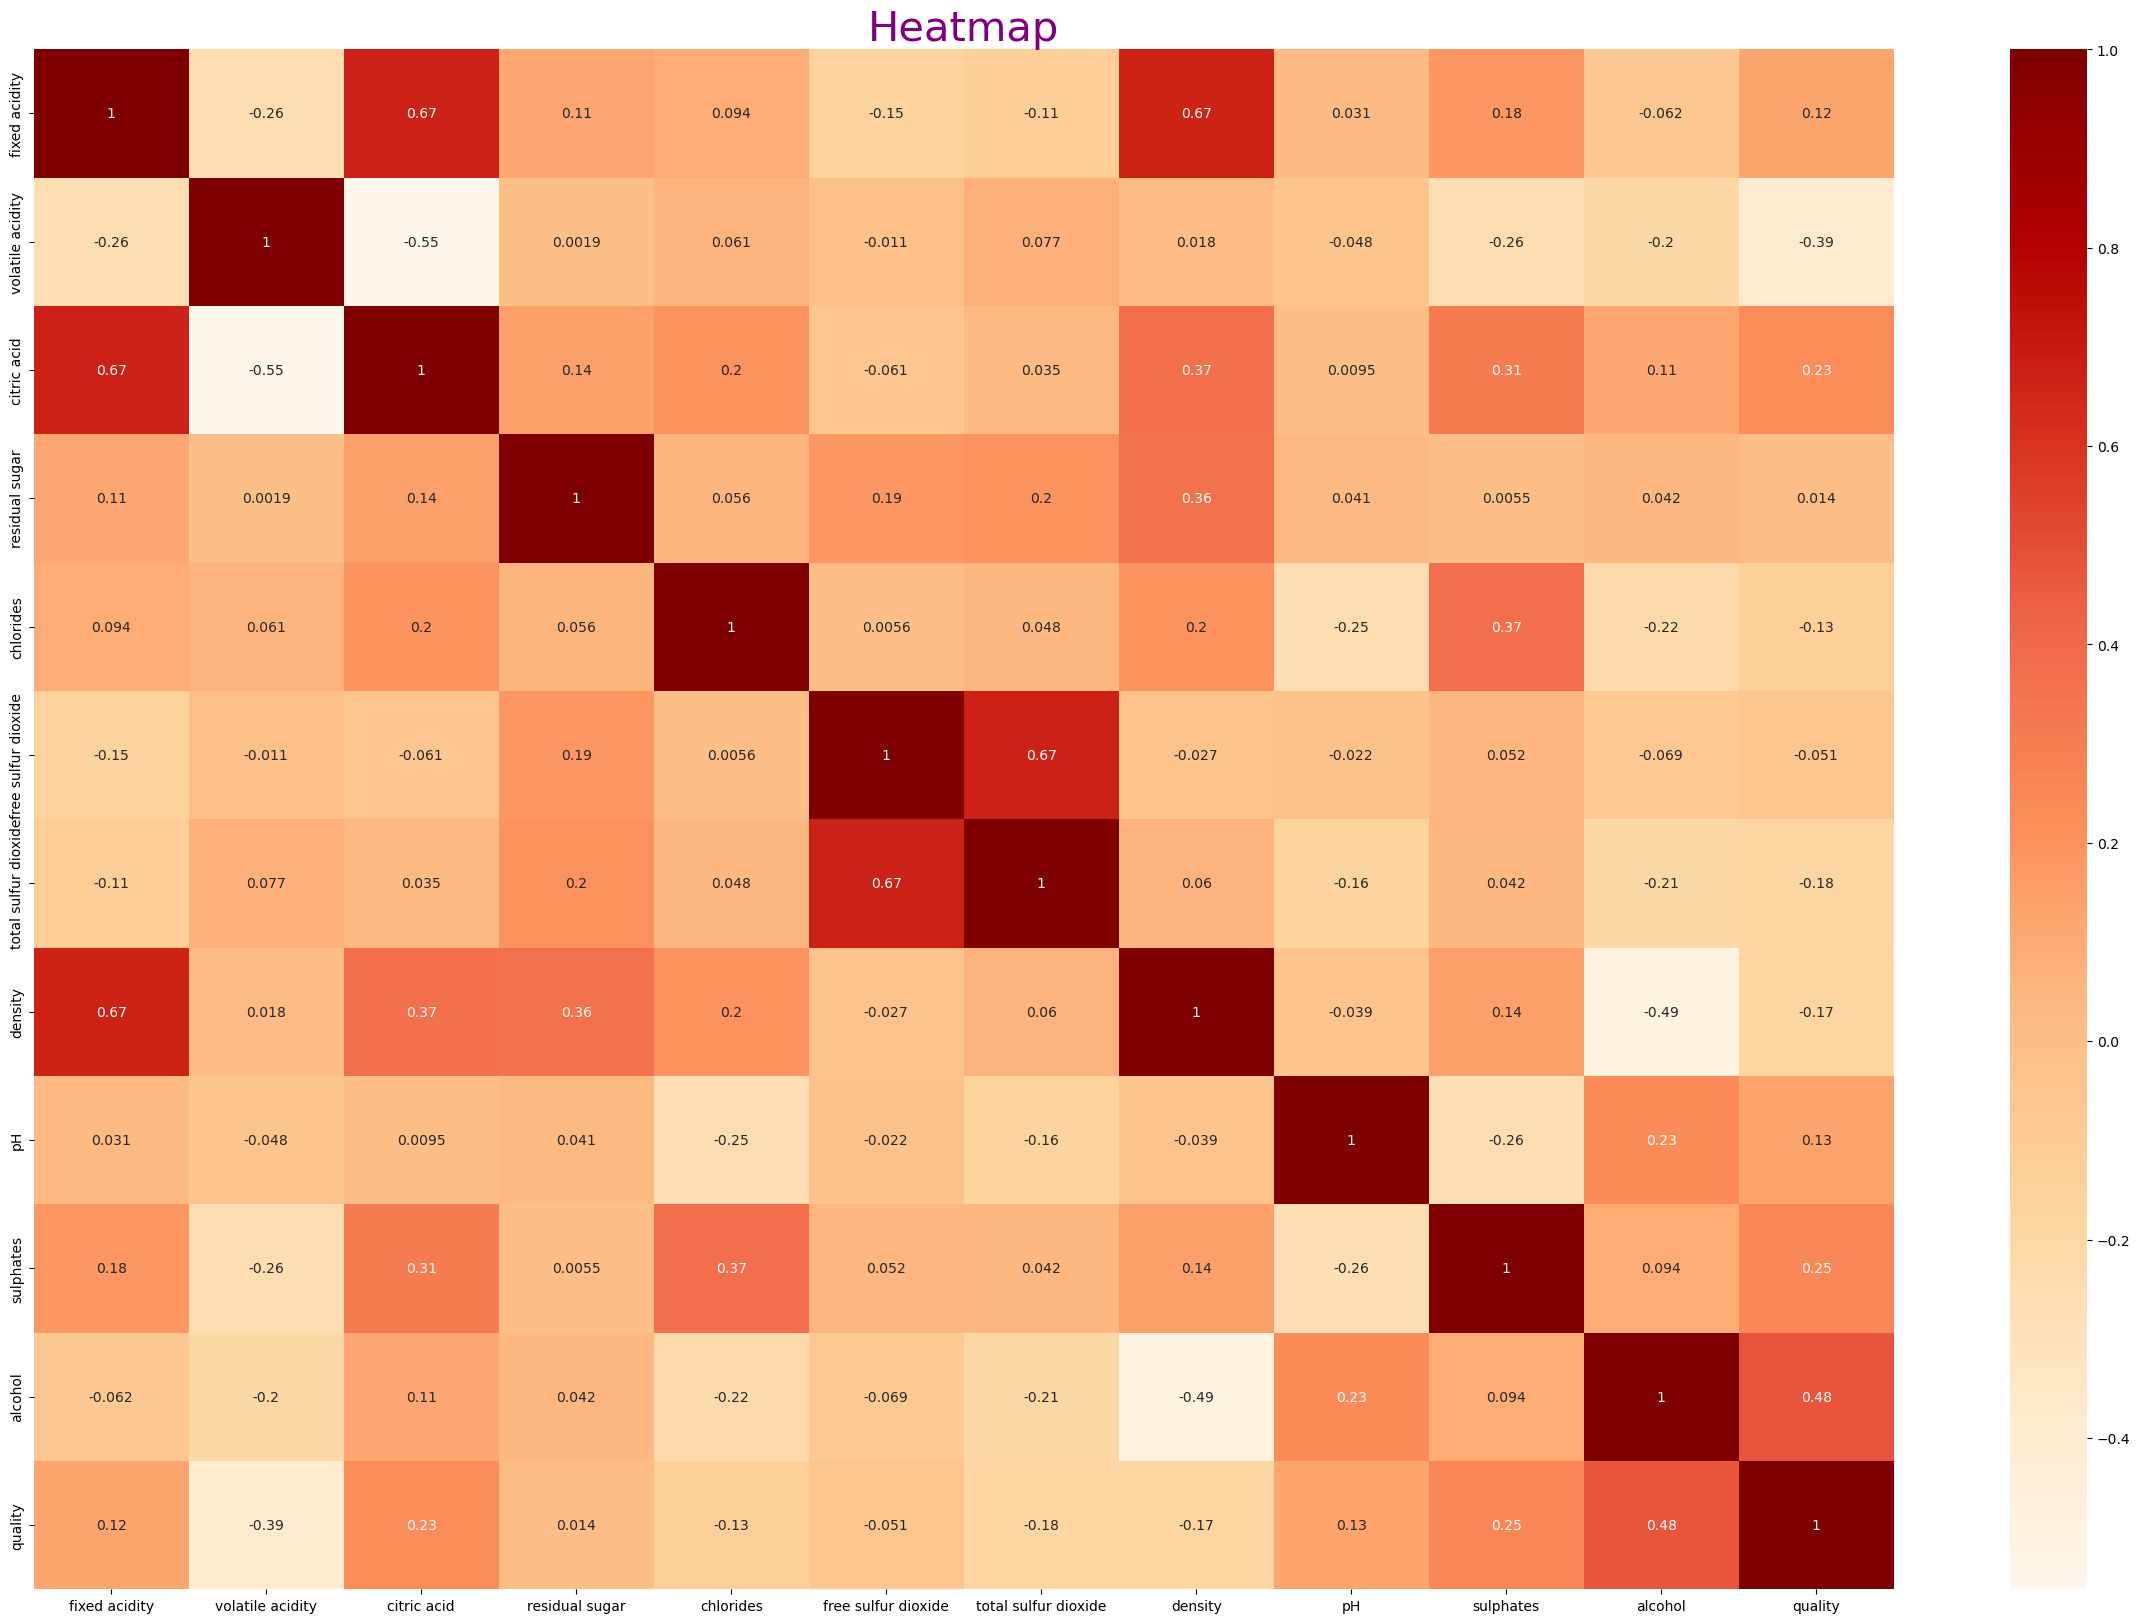

In [56]:
new_model.dataset_corelation_heatmap()

In [57]:
new_model.dataset_split_Xy()

(      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0               7.4             0.700         0.00             1.9      0.076   
 1               7.8             0.880         0.00             2.6      0.098   
 2               7.8             0.760         0.04             2.3      0.092   
 3              11.2             0.280         0.56             1.9      0.075   
 4               7.4             0.700         0.00             1.9      0.076   
 ...             ...               ...          ...             ...        ...   
 1594            6.2             0.600         0.08             2.0      0.090   
 1595            5.9             0.550         0.10             2.2      0.062   
 1596            6.3             0.510         0.13             2.3      0.076   
 1597            5.9             0.645         0.12             2.0      0.075   
 1598            6.0             0.310         0.47             3.6      0.067   
 
       free su

In [58]:
new_model.oversampler_dataset()

Original dataset shape (1599,)
Resample dataset shape (4086,)
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
4081           12.6              0.31         0.72             2.2      0.072   
4082           12.6              0.31         0.72             2.2      0.072   
4083            8.6              0.42         0.39             1.8      0.068   
4084            5.0              0.42         0.24             2.0      0.060   
4085            5.0              0.42         0

In [59]:
new_model.scaled_data()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.510355,0.476596,-1.235048,-0.495999,-0.251461,-0.282611,-0.141383,0.692961,0.066348,-0.580708,-1.063952
1,-0.294607,1.176131,-1.235048,-0.015457,0.152765,1.090688,0.976203,0.216368,-3.682124,0.092180,-0.743751
2,-0.294607,0.709774,-1.054845,-0.221404,0.042522,0.109760,0.535942,0.216368,-2.956613,-0.076042,-0.743751
3,1.539251,-1.155653,1.287795,-0.495999,-0.269834,0.305946,0.739140,0.692961,-4.165798,-0.468560,-0.743751
4,-0.510355,0.476596,-1.235048,-0.495999,-0.251461,-0.282611,-0.141383,0.692961,0.066348,-0.580708,-1.063952
...,...,...,...,...,...,...,...,...,...,...,...
4081,2.294369,-1.039064,2.008608,-0.290052,-0.324956,-0.773075,-0.310714,1.169554,0.187267,0.877217,-0.743751
4082,2.294369,-1.039064,2.008608,-0.290052,-0.324956,-0.773075,-0.310714,1.169554,0.187267,0.877217,-0.743751
4083,0.136889,-0.611570,0.521932,-0.564648,-0.398452,-0.773075,-0.886440,-0.736818,0.187267,0.148255,0.777206
4084,-1.804844,-0.611570,-0.153830,-0.427350,-0.545443,0.502131,0.400477,-2.166596,0.187267,0.428625,2.618364


In [60]:
new_model.dataset_train_validation_split()

(      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 2185      -0.887915          0.709774    -1.144947       -0.564648  -0.214713   
 2462      -1.103663          1.720213    -1.235048       -0.427350  -0.122843   
 2819      -0.618229          0.010239     1.197694       -0.358701   0.446747   
 1769      -0.510355          2.361454    -1.235048        1.117250   0.134391   
 1373      -0.348544          0.670911    -0.018677        0.808330   0.373252   
 ...             ...               ...          ...             ...        ...   
 1130       0.406574          0.087965    -1.235048       -0.495999  -0.582191   
 1294      -0.078859          0.223986    -0.784541       -0.358701  -0.306582   
 860       -0.618229          0.165691    -0.964744        0.053192  -0.233087   
 3507       1.593188          0.165691     1.783354        1.769414  -0.067722   
 3174       2.402243         -1.077927     2.098709       -0.015457   0.097643   
 
       free su

In [61]:
new_model.rfe_cols_name()

,volatile acidity,chlorides,total sulfur dioxide,sulphates,alcohol
2185,0.709774,-0.214713,-0.886440,-0.188190,-0.623675
2462,1.720213,-0.122843,-0.480045,-0.636782,0.376954
2819,0.010239,0.446747,-0.988039,-0.524634,-0.343499
1769,2.361454,0.134391,-0.818708,-0.692856,-0.023298
1373,0.670911,0.373252,1.721261,-1.197523,-1.144003
...,...,...,...,...,...
1130,0.087965,-0.582191,-0.954173,-0.188190,-0.263449
1294,0.223986,-0.306582,0.739140,0.484699,0.136803
860,0.165691,-0.233087,1.585796,-0.692856,-0.983902
3507,0.165691,-0.067722,-0.649377,0.148255,2.138062


In [62]:
new_model.model_vif()

,Features,vif
3,sulphates,1.62
1,chlorides,1.43
0,volatile acidity,1.37
4,alcohol,1.20
2,total sulfur dioxide,1.04


In [63]:
new_model.dataset_null_check()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [64]:
new_model.quality_predict_regression()

Epoch 1/200
71/71 [==============================] - 1s 11ms/step - loss: 6.0940 - val_loss: 1.5070
Epoch 2/200
71/71 [==============================] - 1s 10ms/step - loss: 1.0503 - val_loss: 0.5797
Epoch 3/200
71/71 [==============================] - 1s 10ms/step - loss: 0.5227 - val_loss: 0.3568
Epoch 4/200
71/71 [==============================] - 1s 10ms/step - loss: 0.3941 - val_loss: 0.3509
Epoch 5/200
71/71 [==============================] - 1s 10ms/step - loss: 0.3541 - val_loss: 0.3317
Epoch 6/200
71/71 [==============================] - 1s 10ms/step - loss: 0.3371 - val_loss: 0.4253
Epoch 7/200
71/71 [==============================] - 1s 10ms/step - loss: 0.3671 - val_loss: 0.2865
Epoch 8/200
71/71 [==============================] - 1s 10ms/step - loss: 0.2597 - val_loss: 0.2409
Epoch 9/200
71/71 [==============================] - 1s 10ms/step - loss: 0.2598 - val_loss: 0.2560
Epoch 10/200
71/71 [==============================] - 1s 10ms/step - loss: 0.2765 - val_loss: 0.2534

71/71 [==============================] - 1s 10ms/step - loss: 0.0146 - val_loss: 0.0732
Epoch 163/200
71/71 [==============================] - 1s 10ms/step - loss: 0.0164 - val_loss: 0.0989
Epoch 164/200
71/71 [==============================] - 1s 10ms/step - loss: 0.0241 - val_loss: 0.0704
Epoch 165/200
71/71 [==============================] - 1s 10ms/step - loss: 0.0131 - val_loss: 0.0828
Epoch 166/200
71/71 [==============================] - 1s 10ms/step - loss: 0.0100 - val_loss: 0.0882
Epoch 167/200
71/71 [==============================] - 1s 10ms/step - loss: 0.0132 - val_loss: 0.0941
Epoch 168/200
71/71 [==============================] - 1s 10ms/step - loss: 0.0112 - val_loss: 0.0874
Epoch 169/200
71/71 [==============================] - 1s 10ms/step - loss: 0.0081 - val_loss: 0.0764
Epoch 170/200
71/71 [==============================] - 1s 10ms/step - loss: 0.0065 - val_loss: 0.0914
Epoch 171/200
71/71 [==============================] - 1s 10ms/step - loss: 0.0351 - val_loss: 0

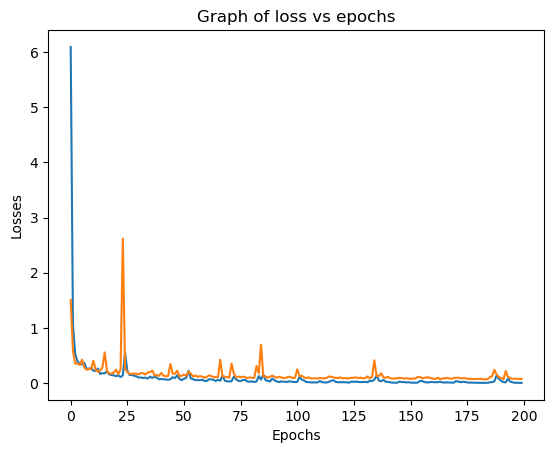

In [65]:
new_model.Regression_training_graph_show()

In [66]:
new_model.final_dataset()

      volatile acidity  chlorides  total sulfur dioxide  sulphates   alcohol  \
2185          0.709774  -0.214713             -0.886440  -0.188190 -0.623675   
2462          1.720213  -0.122843             -0.480045  -0.636782  0.376954   
2819          0.010239   0.446747             -0.988039  -0.524634 -0.343499   
1769          2.361454   0.134391             -0.818708  -0.692856 -0.023298   
1373          0.670911   0.373252              1.721261  -1.197523 -1.144003   
...                ...        ...                   ...        ...       ...   
1130          0.087965  -0.582191             -0.954173  -0.188190 -0.263449   
1294          0.223986  -0.306582              0.739140   0.484699  0.136803   
860           0.165691  -0.233087              1.585796  -0.692856 -0.983902   
3507          0.165691  -0.067722             -0.649377   0.148255  2.138062   
3174         -1.077927   0.097643             -0.344580   0.596847  0.056753   

      quality  quality_predict  
2185  

# Classification Using XGBoost

In [4]:
data=pd.read_csv("wine_quality.csv",header=0)
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5.0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5.0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6.0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.52,0.58,10.5,5.0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.52,0.75,11.0,6.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.52,0.71,10.2,5.0


In [5]:
data.fillna(data.mean(),inplace=True)

In [6]:
for i in range(len(data["quality"])):
    if(data["quality"][i]<=3):
        data["quality"][i]=0
    elif(data["quality"][i]<=6 and data["quality"][i]>3 ):
        data["quality"][i]=1 
    else:
        data["quality"][i]=2

In [7]:
y=data["quality"]
y=y.astype("int")
y

0       1
1       1
2       1
3       1
4       1
       ..
1594    1
1595    1
1596    1
1597    1
1598    1
Name: quality, Length: 1599, dtype: int64

In [8]:
X=data.drop("quality",axis=1)
X["total sulfur dioxide"]=X["total sulfur dioxide"].astype("int")
X["free sulfur dioxide"]=X["free sulfur dioxide"].astype("int")
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11,34,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25,67,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15,54,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17,60,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11,34,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32,44,0.99490,3.52,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39,51,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.52,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.52,0.71,10.2


In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)


In [10]:
ros = RandomOverSampler(random_state=42)

# fit predictor and target variable

x_ros, y_ros = ros.fit_resample(X, y)

print('Original dataset shape', y.shape)
print('Resample dataset shape', y_ros.shape)

Original dataset shape (1599,)
Resample dataset shape (4116,)


In [11]:

xgclf = xgb.XGBClassifier()

xgclf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [12]:
metrics.accuracy_score(y_train,xgclf.predict(X_train))

1.0

In [13]:
metrics.accuracy_score(y_test,xgclf.predict(X_test))

0.903125

## For XGBClassifier I have got accuracy of 90.3% for validation data .thats mean this model can detect the quality of the wine 90.3 % correctly.

In [40]:
testing_data={"fixed acidity":10.2,"volatile acidity":0.5,"citric acid":0,"residual sugar":2.5,"chlorides":0.045,"free sulfur dioxide":10,"total sulfur dioxide":55,"density":0.56,"pH":3.36,"sulphates":0.56,"alcohol":10.5}
test_data=pd.DataFrame(testing_data,index=[0])
test_data
predicted=xgclf.predict(test_data)
if predicted==1:
    print("Average quality")
elif predicted==0:
    print("Poor quality")
else:
    print("Excelent Quality")
    

Average quality


In [41]:
testing_data={"fixed acidity":9.1,"volatile acidity":0.4,"citric acid":0.5,"residual sugar":1.8,"chlorides":0.071,"free sulfur dioxide":7,"total sulfur dioxide":16,"density":0.99462,"pH":3.52,"sulphates":0.69,"alcohol":12.5}
test_data=pd.DataFrame(testing_data,index=[0])
test_data
predicted=xgclf.predict(test_data)
if predicted==1:
    print("Average quality")
elif predicted==0:
    print("Poor quality")
else:
    print("Excelent Quality")

Excelent Quality
